# **Predicting Churn for Bank Customers**

# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

#Libraries for model building
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTENC

# Reading & Understanding the data

In [2]:
df = pd.read_csv('Churn_Modelling.csv')

In [3]:
# Dropping unnecessary columns
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [4]:
df.sample(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
916,475,France,Male,39,6,0.00,1,1,1,56999.90,1
8938,693,Spain,Male,47,8,107604.66,1,1,1,80149.27,0
4031,688,Spain,Male,37,7,138162.41,2,1,1,113926.31,0
3169,677,Spain,Male,40,5,0.00,2,1,0,88947.56,0
6679,470,Spain,Male,30,4,125385.01,1,1,0,68293.93,0
7889,600,Germany,Male,57,9,138456.03,2,1,1,103548.25,0
854,675,France,Female,57,8,0.00,2,0,1,95463.29,0
5138,850,France,Male,34,6,0.00,1,0,1,52796.31,0
3230,679,France,Female,33,6,0.00,2,1,1,98015.85,0
4449,666,France,Male,36,3,0.00,2,1,0,35156.54,0


In [5]:
df.shape

(10000, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [7]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# Exploratory Data Analysis

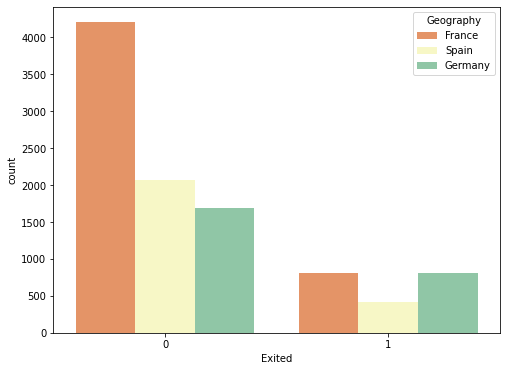

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(x= df.Exited, hue=df.Geography, palette = "Spectral")
plt.show()

**Inferences** 
1.   As we can see from the plot that the data is higly skewed, the count for non-Exited customers is higher than the Exited customers.
2.   The non-Exited customer count for France is high around 4000, whereas for Spain is around 2000 and Germany 1500.
3.   The Exited customer count for France and Germany is same around 700, whereas for spain is around 400.




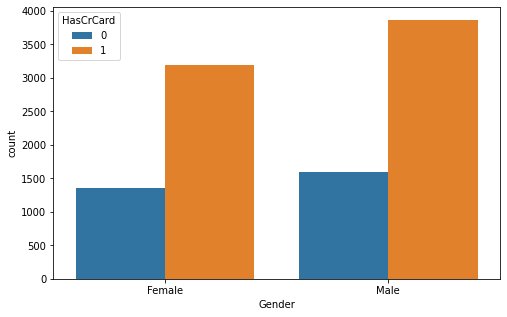

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(x= df.Gender, hue=df.HasCrCard)
plt.show()

**Inferences** 
1.   70% of the customers are having a credit card.
2.   37% of the customers using credit card are Male and remaining 33% are Female. 

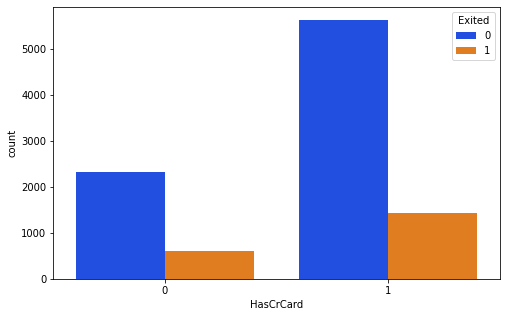

In [10]:
plt.figure(figsize=(8,5))
sns.countplot(x= df.HasCrCard, hue=df.Exited, palette = "bright")
plt.show()

**Inferences** 
1.   The count for non-Exited customers having credit card is higher around 6000, whereas for the Exited customers having credit card is lesser around 1200.
2.   The count for non-Exited customers not having credit card is higher around 2200, whereas for the Exited customers not having credit card is around 500.

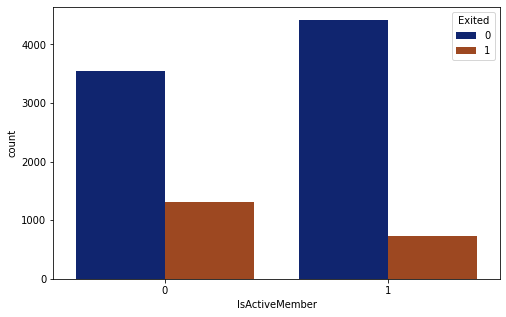

In [11]:
plt.figure(figsize=(8,5))
sns.countplot(x= df.IsActiveMember, hue=df.Exited, palette = "dark")
plt.show()

**Inferences** 
1.   The count for non-Exited/Active customers is higher around 5000, whereas for the Exited/Active customers is lesser around 700.
2.   The count for non-Exited/non-Active customers is higher around 3500, whereas for the Exited/non-Active customers is around 1200.

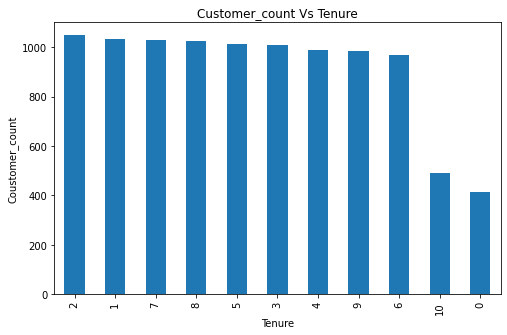

In [12]:
plt.figure(figsize=(8,5))
df.Tenure.value_counts().plot(kind='bar')
plt.title('Customer_count Vs Tenure')
plt.xlabel('Tenure')
plt.ylabel('Coustomer_count')
plt.show()

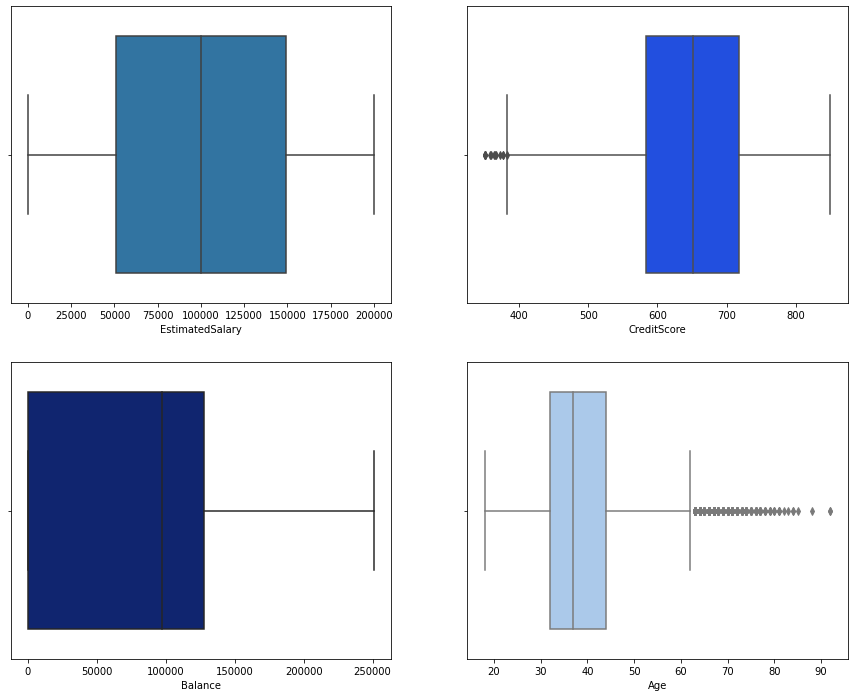

In [13]:
plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
sns.boxplot(x= df.EstimatedSalary, palette='tab10')
plt.subplot(2,2,2)
sns.boxplot(x= df.CreditScore, palette='bright')
plt.subplot(2,2,3)
sns.boxplot(x= df.Balance, palette='dark')
plt.subplot(2,2,4)
sns.boxplot(x= df.Age, palette='pastel')
plt.show()

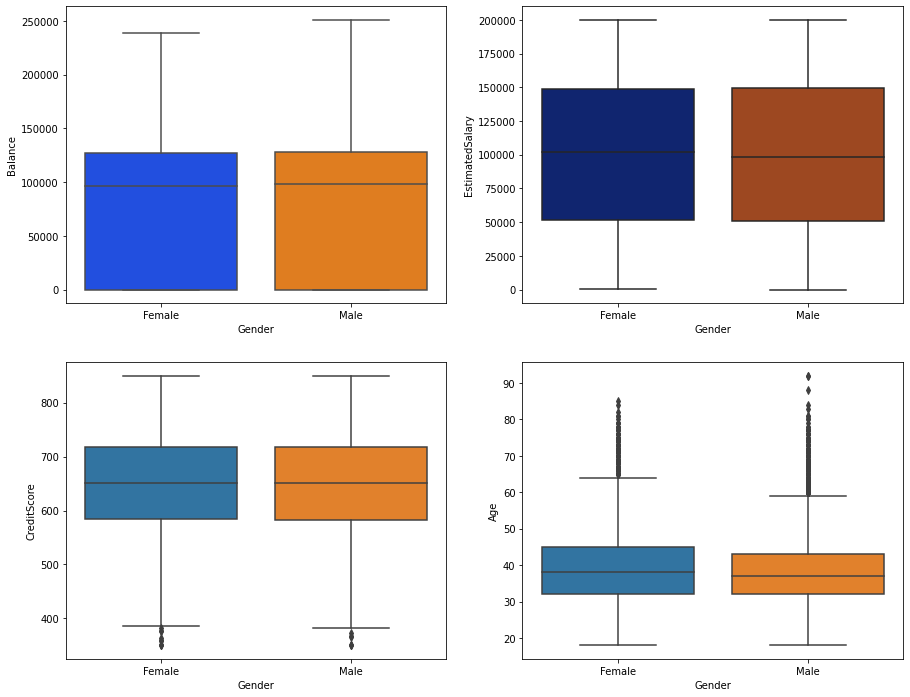

In [14]:
plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
sns.boxplot(x=df.Gender,y= df.Balance, palette='bright')
plt.subplot(2,2,2)
sns.boxplot(x=df.Gender,y= df.EstimatedSalary, palette='dark')
plt.subplot(2,2,3)
sns.boxplot(x=df.Gender,y= df.CreditScore, palette='tab10')
plt.subplot(2,2,4)
sns.boxplot(x=df.Gender,y= df.Age)
plt.show()

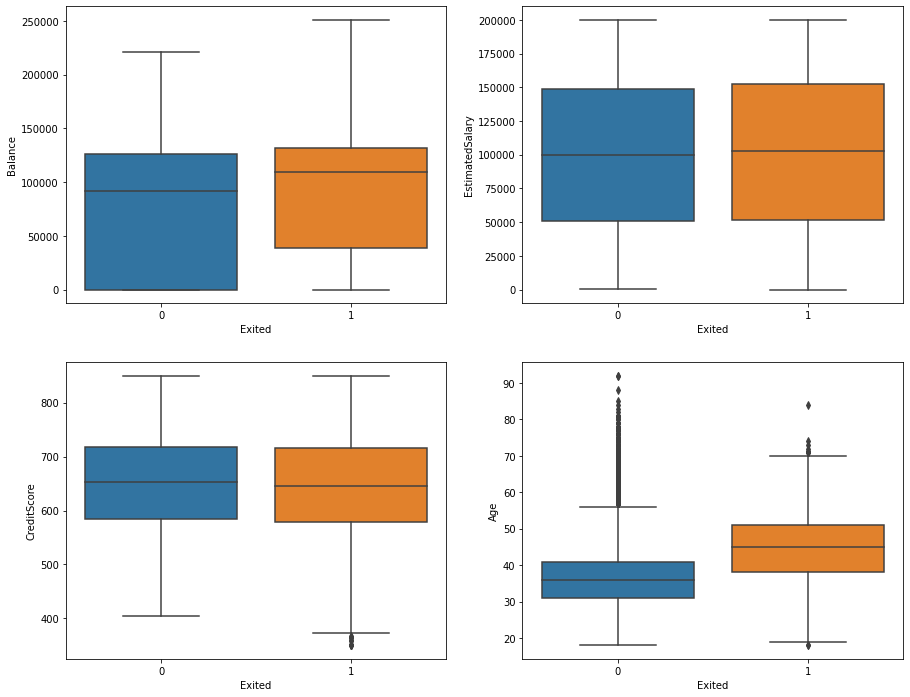

In [15]:
plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
sns.boxplot(x=df.Exited,y= df.Balance)
plt.subplot(2,2,2)
sns.boxplot(x=df.Exited,y= df.EstimatedSalary)
plt.subplot(2,2,3)
sns.boxplot(x=df.Exited,y= df.CreditScore)
plt.subplot(2,2,4)
sns.boxplot(x=df.Exited,y= df.Age)
plt.show()

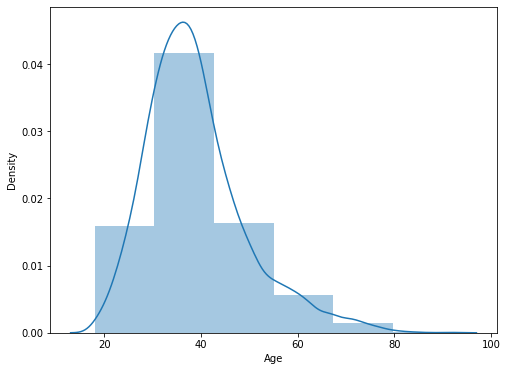

In [16]:
plt.figure(figsize=(8,6))
sns.distplot(df.Age,bins = 6)
plt.show()

**Inferences** 
1.   20% of the Customers belong to age between 20-30.
2.   50% of the Customers belong to age between 30-45.
3.   20% of the Customers belong to age between 45-55.
4.   Remaining 10% of the coustomers belong to age above 60.

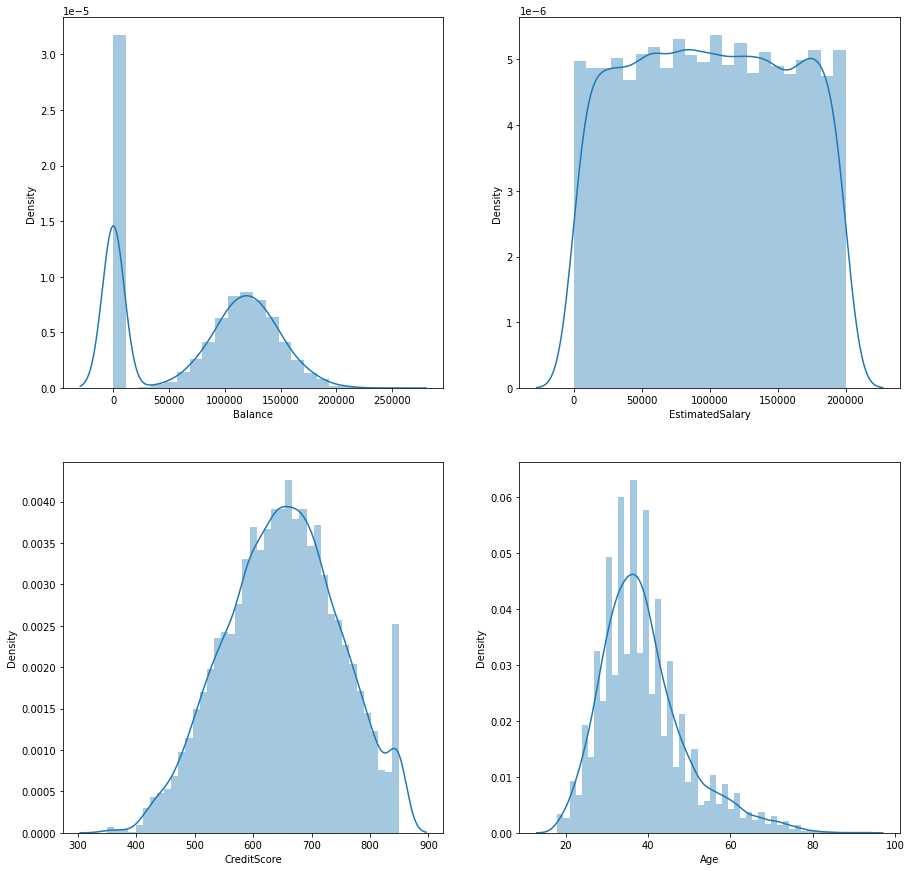

In [17]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.distplot(df.Balance)
plt.subplot(2,2,2)
sns.distplot(df.EstimatedSalary)
plt.subplot(2,2,3)
sns.distplot(df.CreditScore)
plt.subplot(2,2,4)
sns.distplot(df.Age)
plt.show()

## Data Preprocessing before trainng the model



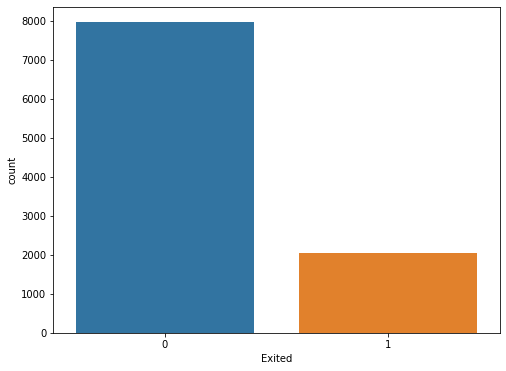

In [18]:
plt.figure(figsize=(8,6))
sns.countplot(df.Exited)
plt.show()

Above figure states that it's an imbalanced dataset. So we shouldn't consider accuracy as our metrics to measure the model, as accuracy is cursed in imbalanced datasets. Hence, to have an balance sampling we are moving ahead to call **SMOTENC** i.e. **Synthetic Minority Over-sampling Technique for Nominal and Continuous**.

In [19]:
X = df.drop(['Exited'],1)
y = df['Exited']

In [20]:
from collections import Counter
print(f'Original dataset samples per class {Counter(y)}')

Original dataset samples per class Counter({0: 7963, 1: 2037})


In [21]:
X.sample(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3353,508,France,Female,31,7,0.00,2,1,1,6123.15
8776,567,Spain,Male,44,9,0.00,2,1,0,87677.15
6377,692,France,Male,33,9,0.00,1,1,0,113505.93
3617,792,Germany,Female,29,4,107601.79,1,1,0,18922.18
1041,722,France,Male,30,5,0.00,2,1,0,166376.54


## SMOTEC Analysis for up-sampling

In [22]:
sm = SMOTENC(categorical_features=[1,2] , random_state=14)
X_samp, y_samp = sm.fit_resample(X,y)

In [23]:
y_samp = pd.Series(y_samp)

In [24]:
X_samp = pd.DataFrame(X_samp, columns=X.columns)

In [25]:
from collections import Counter
print(f'Original dataset samples per class {Counter(y_samp)}')

Original dataset samples per class Counter({1: 7963, 0: 7963})


In [26]:
print(X.shape)
print(y.shape)
print(X_samp.shape)
print(y_samp.shape)

(10000, 10)
(10000,)
(15926, 10)
(15926,)


## Splitting the data into Train and Test

In [27]:
X_train,X_test,y_train,y_test=train_test_split(X, y, train_size=0.7, random_state= 21)

In [28]:
X_train_sm,X_test_sm,y_train_sm,y_test_sm=train_test_split(X_samp, y_samp, train_size=0.7, random_state= 69)

# Making a pipeline

In [29]:
col_trans = make_column_transformer((OneHotEncoder(drop='first'), ['Geography', 'Gender']),(StandardScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']))

# Cross Validation


## Model 1: Logistics Regression

In [30]:
model_lr = LogisticRegression()
pipe = make_pipeline(col_trans, model_lr)
kfold = KFold(n_splits=10)
result_lr = cross_val_score(pipe, X, y, cv=kfold, scoring='accuracy')
print("Accuracy of model using Logistic Regression model is", result_lr.mean())

Accuracy of model using Logistic Regression model is 0.8098000000000001


In [31]:
result_lr_sm = cross_val_score(pipe, X_samp, y_samp, cv=kfold, scoring='accuracy')
print("Accuracy of model using Logistic Regression model with SMOTEE analysis is", result_lr_sm.mean())

Accuracy of model using Logistic Regression model with SMOTEE analysis is 0.7458379862274336


## Model 2: K Nearest Neighbours

In [32]:
model_knn = KNeighborsClassifier()
pipe = make_pipeline(col_trans, model_knn)
kfold = KFold(n_splits=10)
result_knn = cross_val_score(pipe, X, y, cv=kfold, scoring='accuracy')
print("Accuracy of model using K Nearest Neighbours model is", result_knn.mean())

Accuracy of model using K Nearest Neighbours model is 0.8398


In [33]:
result_knn_sm = cross_val_score(pipe, X_samp, y_samp, cv=kfold, scoring='accuracy')
print("Accuracy of model using K Nearest Neighbours model with SMOTEE analysis is", result_knn_sm.mean())

Accuracy of model using K Nearest Neighbours model with SMOTEE analysis is 0.8086897923389703


## Model 3: Naive Bayes

In [34]:
model_nb=GaussianNB()
pipe = make_pipeline(col_trans, model_nb)
kfold = KFold(n_splits=10)
result_nb = cross_val_score(pipe, X, y, cv=kfold, scoring='accuracy')
print("Accuracy of model using Naive Bayes model is", result_nb.mean())

Accuracy of model using Naive Bayes model is 0.8242


In [35]:
result_nb_sm = cross_val_score(pipe, X_samp, y_samp, cv=kfold, scoring='accuracy')
print("Accuracy of model using Naive Bayes model with SMOTEE analysis is", result_nb_sm.mean())

Accuracy of model using Naive Bayes model with SMOTEE analysis is 0.7537469992776185


## Model 3: Random Forest Classifier

In [36]:
model_rf = RandomForestClassifier()
pipe = make_pipeline(col_trans, model_rf)
kfold = KFold(n_splits=10)
result_rf = cross_val_score(pipe, X, y, cv=kfold, scoring='accuracy')
print("Accuracy of model using Random Forest Classifier model is", result_rf.mean())

Accuracy of model using Random Forest Classifier model is 0.8615999999999999


In [37]:
result_rf_sm = cross_val_score(pipe, X_samp, y_samp, cv=kfold, scoring='accuracy')
print("Accuracy of model using Random Forest Classifier model with SMOTEE analysis is", result_rf_sm.mean())

Accuracy of model using Random Forest Classifier model with SMOTEE analysis is 0.8451058651701697


SMOTEE analysis provided an additional insight that with imbalance data, **"Random Forest Classifier"** and **"K Nearest Neighbour"** models perform better than two other models.
Hence, we need to check recall, precision & f1 score for the minority class, and it's quite evident that the precision, recall & f1 score is too low for Class 1, i.e. churned customers. For more understanding, we will check on classification report.

# Classification Report

## Model 1: K Nearest Neighbours

In [38]:
model_knn = KNeighborsClassifier()
pipe = make_pipeline(col_trans, model_knn)
pipe.fit(X_train_sm, y_train_sm)
y_pred_sm= pipe.predict(X_test_sm)

In [39]:
target_names = ['No', 'Yes']
print(classification_report(y_test_sm, y_pred_sm, target_names=target_names))

              precision    recall  f1-score   support

          No       0.84      0.79      0.82      2426
         Yes       0.80      0.85      0.82      2352

    accuracy                           0.82      4778
   macro avg       0.82      0.82      0.82      4778
weighted avg       0.82      0.82      0.82      4778



In [40]:
CM_knn_sm = confusion_matrix(y_test_sm, y_pred_sm)

## Model 4: Random Forest Classifier

In [41]:
model_rf = RandomForestClassifier()
pipe = make_pipeline(col_trans, model_rf)
pipe.fit(X_train_sm, y_train_sm)
y_pred_sm= pipe.predict(X_test_sm)

In [42]:
target_names = ['No', 'Yes']
print(classification_report(y_test_sm, y_pred_sm, target_names=target_names))

              precision    recall  f1-score   support

          No       0.86      0.85      0.85      2426
         Yes       0.85      0.86      0.85      2352

    accuracy                           0.85      4778
   macro avg       0.85      0.85      0.85      4778
weighted avg       0.85      0.85      0.85      4778



In [43]:
CM_rf_sm = confusion_matrix(y_test_sm, y_pred_sm)

### Let's check with confusion matrix which will give the idea about the best fit model for this dataset.

In [44]:
CM_knn_sm

array([[1922,  504],
       [ 357, 1995]], dtype=int64)

In [45]:
CM_rf_sm

array([[2060,  366],
       [ 341, 2011]], dtype=int64)

# Conclusion

The criteria of the loan offer must be done on the basis of minimum amount of false prediction. So that we will create some set of parameters which can help us to select bet fit model. We will go sequencially through the parameters given below:
1. Model must predict maximum **True Positive** and **True Negative** values.
   -*To find best fit model*
   
2. Model must contain less number of **False Negative**.
   -*To minimize the quantity of defaulters*
   
3. Model must contain less number of **False Positive**.
   -*To maximize the bussiness*

The maximum numbers of True positive and True Negative are almost same. But the logistics contains least numbers of False Negative compared to other models. Also highest number of correct prediction among all the models.

### **So we have came to conclusion that "Random Forest Classifier" is the best fit model for given dataset.**

# Saving the best fit model for deployment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/')
import pickle
filename = 'Bank_Loan_model.pkl'
pickle.dump(pipe, open(filename, 'wb'))